In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

2025-02-28 21:24:12.769187: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# Load dataset
file_path = 'only_3_sorted_stock_data_cleaned_nica.csv'

# data_all = 
data_with_close=pd.read_csv(file_path)
# data_all=data_with_close['close']

KeyError: 'close'

In [3]:
data_with_close

,Close,Qty,EPS
0,660.0,3547.0,17.94
1,651.0,5758.0,17.94
2,646.0,6085.0,17.94
3,648.0,6977.0,17.94
4,648.0,3303.0,17.94
...,...,...,...
1915,363.0,47627.0,2.04
1916,370.7,70533.0,2.04
1917,382.0,108899.0,2.04
1918,377.0,74518.0,2.04


In [5]:
data_all=data_with_close['Close']

In [3]:

# Train-Test Split
data_train = data_all[:int(len(data_all)*0.80)]
data_test = data_all[int(len(data_all)*0.80):]


In [4]:
# Normalize the dataset
scaler = MinMaxScaler()
data_train_scaled = scaler.fit_transform(data_train)

In [5]:
data_train_scaled

array([[0.46709677, 0.00517072, 0.27394474],
       [0.45548387, 0.00844932, 0.27394474],
       [0.44903226, 0.00893421, 0.27394474],
       ...,
       [0.61548387, 0.21061162, 0.76250212],
       [0.61935484, 0.08031597, 0.76250212],
       [0.61935484, 0.06584032, 0.76250212]])

In [6]:
# Convert data into sequences
def create_sequences(data, seq_length=50):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 50  # Lookback period
X_train, y_train = create_sequences(data_train_scaled, seq_length)

In [7]:
X_train.shape, y_train.shape

((1486, 50, 3), (1486, 3))

In [ ]:
# Build LSTM model
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(128, activation='tanh', return_sequences=True),
    Dropout(0.3),
    LSTM(64, activation='tanh', return_sequences=True),
    Dropout(0.3),
    LSTM(32, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(1)  # Predicting all 8 features
])

In [9]:
# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)
model.save("lstm_final.keras")

Epoch 1/50
47/47 [==============================] - 7s 65ms/step - loss: 0.0272
Epoch 2/50
47/47 [==============================] - 3s 68ms/step - loss: 0.0119
Epoch 3/50
47/47 [==============================] - 3s 65ms/step - loss: 0.0099
Epoch 4/50
47/47 [==============================] - 3s 65ms/step - loss: 0.0100
Epoch 5/50
47/47 [==============================] - 3s 64ms/step - loss: 0.0100
Epoch 6/50
47/47 [==============================] - 3s 65ms/step - loss: 0.0088
Epoch 7/50
47/47 [==============================] - 3s 66ms/step - loss: 0.0087
Epoch 8/50
47/47 [==============================] - 3s 65ms/step - loss: 0.0084
Epoch 9/50
47/47 [==============================] - 3s 67ms/step - loss: 0.0079
Epoch 10/50
47/47 [==============================] - 3s 64ms/step - loss: 0.0075
Epoch 11/50
47/47 [==============================] - 3s 64ms/step - loss: 0.0071
Epoch 12/50
47/47 [==============================] - 3s 65ms/step - loss: 0.0069
Epoch 13/50
47/47 [==================

In [10]:
# Prepare Test Data
data_test_scaled=scaler.transform(data_test)
# Convert data into sequences
def create_sequences(data_test, seq_length=50):
    X, y = [], []
    for i in range(len(data_test) - seq_length):
        X.append(data_test[i:i+seq_length])
        y.append(data_test[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 50  # Lookback period
X_test, y_test = create_sequences(data_test_scaled, seq_length)


In [ ]:
# Make Predictions
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
# y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))
y_test_actual = (scaler.inverse_transform(y_test.reshape(-1,1))).reshape(y_test.shape)

11/11 [==============================] - 1s 22ms/step


In [12]:
# Assuming 'Close' is the 0th feature and 'PE Ratio' is the 5th feature in the dataset
# Extract the actual test values
X_test_close = y_test_actual[:, 0]  # Actual Close values from test data
X_test_pe = y_test_actual[:, 2]  # Actual PE Ratio values from test data
y_pred_close=y_pred[:,0]
y_pred_pe=y_pred[:,2]


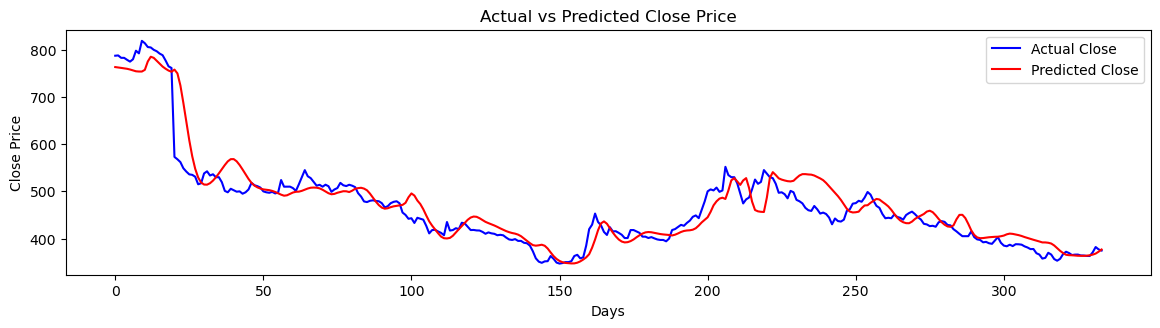

In [13]:
# Plot actual vs predicted values for Close and PE Ratio
plt.figure(figsize=(14, 7))

# Plot Close
plt.subplot(2, 1, 1)
plt.plot(X_test_close, label="Actual Close", color="blue")
plt.plot(y_pred_close, label="Predicted Close", color="red")
plt.xlabel("Days")
plt.ylabel("Close Price")
plt.title("Actual vs Predicted Close Price")
plt.legend()


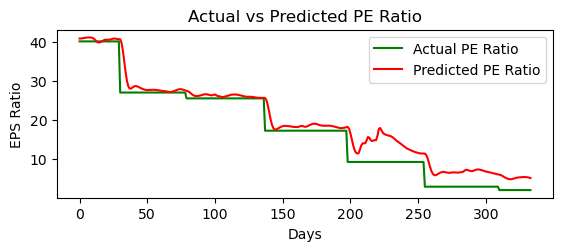

In [14]:
# Plot PE Ratio
plt.subplot(2, 1, 2)
plt.plot(X_test_pe, label="Actual PE Ratio", color="green")
plt.plot(y_pred_pe, label="Predicted PE Ratio",  color="red")
plt.xlabel("Days")
plt.ylabel("EPS Ratio")
plt.title("Actual vs Predicted PE Ratio")
plt.legend()

In [31]:
##For Future prediction
last_50_datas=data_all[-seq_length:]

In [33]:
last_50_datas

,Close,Qty,EPS
1870,415.2,143772.0,2.91
1871,409.9,155704.0,2.91
1872,405.0,159922.0,2.91
1873,405.0,66907.0,2.91
1874,405.0,58539.0,2.91
1875,415.0,150942.0,2.91
1876,403.0,84801.0,2.91
1877,398.2,113101.0,2.91
1878,397.0,80508.0,2.91
1879,392.0,83131.0,2.91


In [34]:
#Scale the data
last_50_datas_scaled=scaler.transform(last_50_datas)

In [35]:
#making predictions
def predict_next_n_days(model, data_scaled, n_days=100):
    predictions=[]
    input_sequence=data_scaled[-seq_length:].copy()

    for _ in range(n_days):
        input_data = np.expand_dims(input_sequence, axis=0)  # Reshape for model input
        next_day_features = model.predict(input_data, verbose=0)[0]  # Predict next day
        predictions.append(next_day_features)
        
        # Update input sequence: Remove first day, add predicted day
        next_day_input = np.append(input_sequence[1:], [next_day_features], axis=0)
        input_sequence = next_day_input
        
    return np.array(predictions)

In [58]:
# Example usage
# last_100_days = scaler.transform(last_100_days_raw)  # Normalize input if needed
predicted_features = predict_next_n_days(model, last_50_datas_scaled, n_days=1050)

In [59]:
predicted_features

array([[0.10602129, 0.09682418, 0.05534345],
       [0.10857539, 0.09876922, 0.05682549],
       [0.11047715, 0.09923705, 0.06288531],
       ...,
       [0.16282609, 0.11958981, 0.45927575],
       [0.16282625, 0.1195898 , 0.45927596],
       [0.16282645, 0.11958979, 0.45927614]], dtype=float32)

In [60]:
predicted_features_inverse = scaler.inverse_transform(predicted_features)

In [61]:
predicted_features_inverse

array([[3.8016650e+02, 6.5355715e+04, 5.0447102e+00],
       [3.8214594e+02, 6.6667398e+04, 5.1321354e+00],
       [3.8361978e+02, 6.6982891e+04, 5.4896045e+00],
       ...,
       [4.2419025e+02, 8.0708258e+04, 2.8872677e+01],
       [4.2419034e+02, 8.0708250e+04, 2.8872690e+01],
       [4.2419052e+02, 8.0708250e+04, 2.8872700e+01]], dtype=float32)

In [62]:
predicted_features_inverse[0]

array([3.8016650e+02, 6.5355715e+04, 5.0447102e+00], dtype=float32)

In [63]:
predicted_features_inverse[0][0]

380.1665

In [64]:
x_future_close=predicted_features_inverse[:, 0]


In [65]:
x_future_close

array([380.1665 , 382.14594, 383.61978, ..., 424.19025, 424.19034,
       424.19052], dtype=float32)

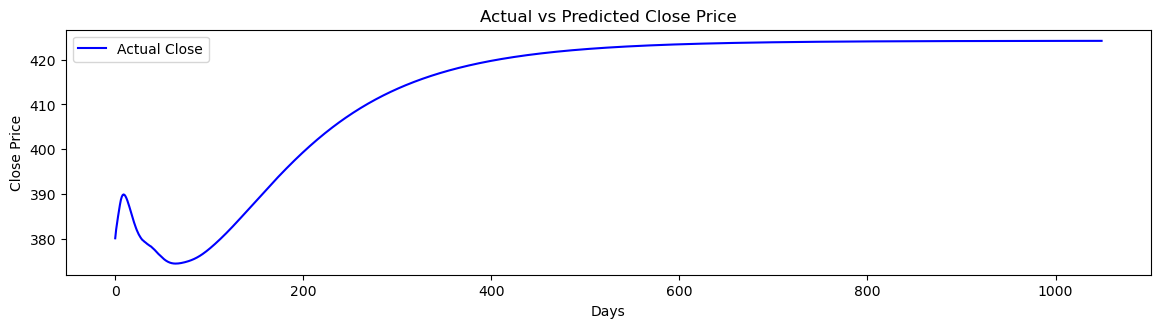

In [66]:
# Plot actual vs predicted values for Close and PE Ratio
plt.figure(figsize=(14, 7))

# Plot Close
plt.subplot(2, 1, 1)
plt.plot(x_future_close, label="Actual Close", color="blue")
# plt.plot(y_pred_close, label="Predicted Close", color="red")
plt.xlabel("Days")
plt.ylabel("Close Price")
plt.title("Actual vs Predicted Close Price")
plt.savefig('future_predict')
plt.legend()


In [57]:
predicted_data=predicted_features_inverse

In [46]:
predicted_features_inverse.shape

(150, 3)

In [47]:
# predicted_data.t
df=pd.DataFrame(predicted_data)
df.to_csv("prediction.csv", index=False)